Implementing Grid Search on keras, based on this <a href="https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/"> tutorial</a> 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("horizon_unpivot.csv")
df = df.dropna()

In [3]:
features = ['opp_goal_difference_last', 'ha', 'opp_goal_difference_5MA', 'opp_goal_difference_10MA',
       'since_last_win', 'goal_difference_5MA', 'goal_difference_10MA', 'goal_difference_last',
        'yellow_cards_referee_hist','odds_5MA', 'odds_10MA', 'odds_last']

In [4]:
df["class_var"] = np.where(df["goal_difference"].gt(1),1, 0)

In [5]:
df["ha"] = np.where(df["ha"].eq("h"),1,0)

In [6]:
df = df.loc[:, features + ["class_var"]]

df = df.sample(frac=1)

fraud_df = df.loc[df['class_var'] == 1]
non_fraud_df = df.loc[df['class_var'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,opp_goal_difference_last,ha,opp_goal_difference_5MA,opp_goal_difference_10MA,since_last_win,goal_difference_5MA,goal_difference_10MA,goal_difference_last,yellow_cards_referee_hist,odds_5MA,odds_10MA,odds_last,class_var
48,1.0,1,0.0,0.0,0.0,0.8,0.7,3.0,3.200000,2.580,3.319,2.35,0
1602,0.0,1,0.4,-1.1,1.0,1.4,1.3,-3.0,4.600000,1.882,1.739,2.55,1
97,1.0,1,0.8,0.5,4.0,-0.6,-1.0,-1.0,4.000000,6.660,5.480,5.75,0
1547,0.0,0,-0.6,-1.4,0.0,2.0,1.2,2.0,3.692308,1.796,2.323,1.31,1
59,-1.0,0,-0.8,-0.4,3.0,-1.6,-1.5,0.0,3.166667,4.890,5.984,2.65,0


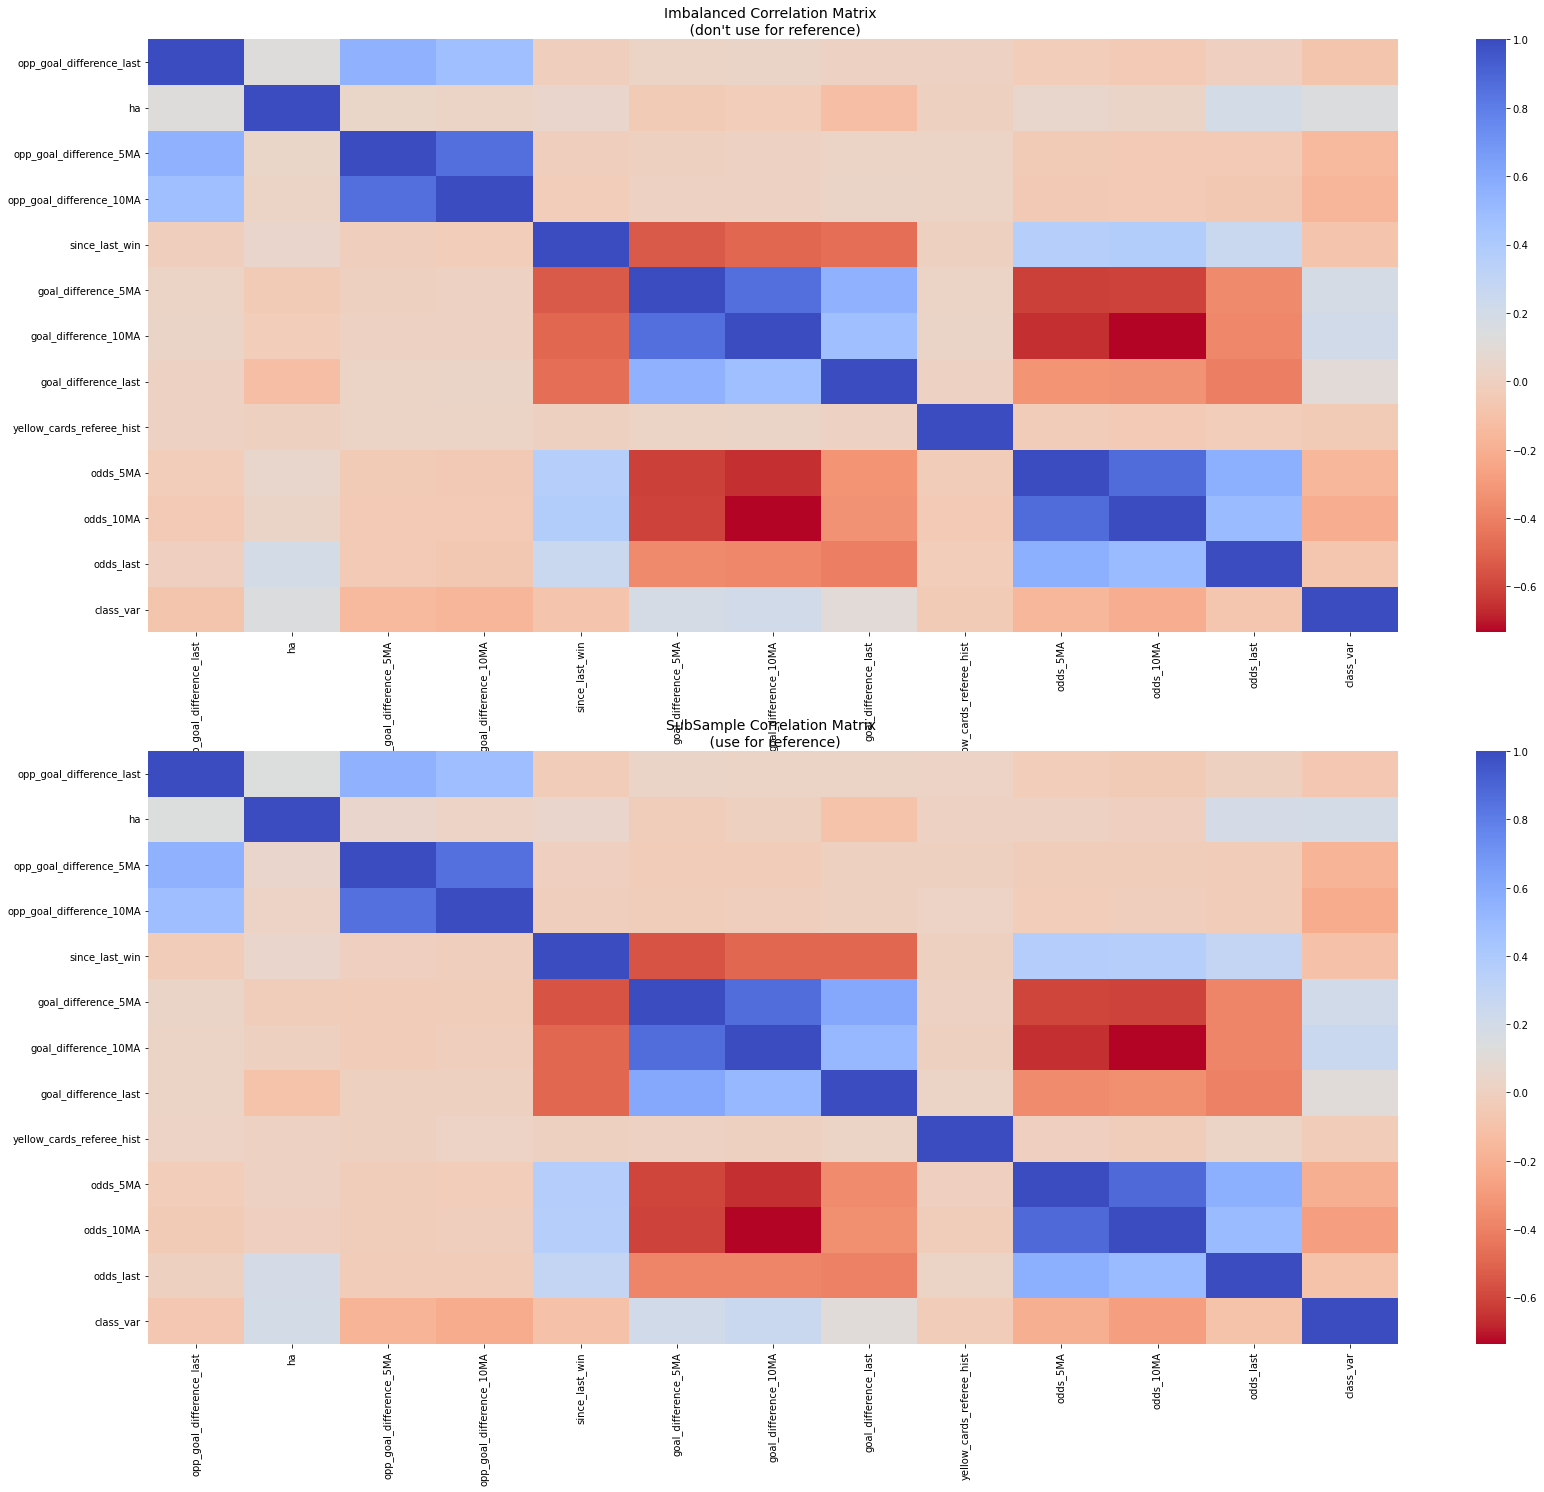

In [7]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(28,24))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

plt.show()

In [8]:
to_be_adjusted = sub_sample_corr["class_var"].drop("class_var").abs().sort_values()[-5:].index

C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

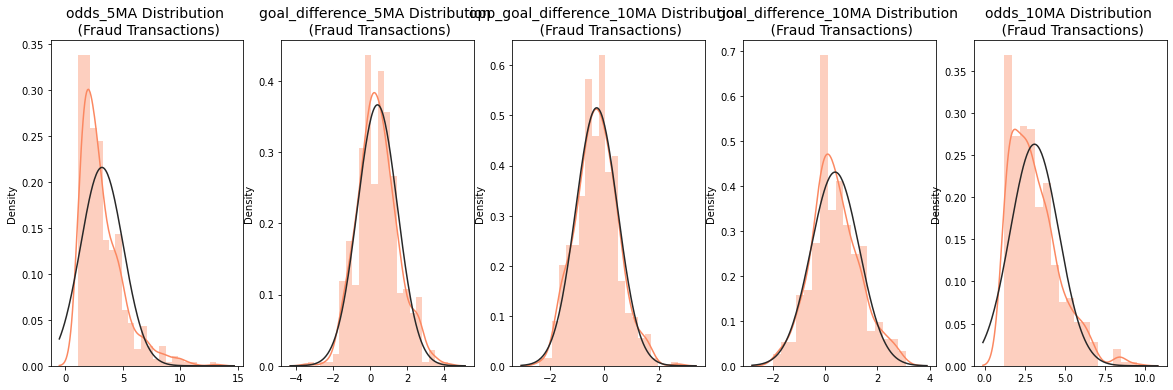

In [9]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5 , figsize=(20, 6))

available_axes = [ax1, ax2, ax3, ax4, ax5]

for i, attr in enumerate(to_be_adjusted):
    v14_fraud_dist = new_df[attr].loc[new_df['class_var'] == 1].values
    sns.distplot(v14_fraud_dist,ax=available_axes[i], fit=norm, color='#FB8861')
    available_axes[i].set_title(f'{attr} Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

We scale with the Standard Scaler. That is the features are normalized. Models usually work better when this is the case.

In [10]:
for attr in to_be_adjusted:
    attr_fraud = new_df[attr].loc[new_df['class_var'] == 1].values
    q25, q75 = np.percentile(attr_fraud, 25), np.percentile(attr_fraud, 75)
    attr_iqr = q75 - q25

    attr_cut_off = attr_iqr * 1.5
    attr_lower, attr_upper = q25 - attr_cut_off, q75 + attr_cut_off
    print(f'{attr} Lower: {attr_lower}')
    print(f'{attr} Upper: {attr_upper}')
    outliers = [x for x in attr_fraud if x < attr_lower or x > attr_upper]
    print(f'{attr} outliers: {outliers}')
    print(f'Feature {attr} Outliers for Fraud Cases: {len(outliers)}')
    new_df = new_df.drop(new_df[(new_df[attr] > attr_upper) | (new_df[attr] < attr_lower)].index)
    print(f'Number of Instances after outliers removal: {len(new_df)}')

odds_5MA Lower: -1.448999999999998
odds_5MA Upper: 7.326999999999998
odds_5MA outliers: [9.720000000000002, 9.82, 13.067999999999998, 7.339999999999998, 8.0, 8.669999999999998, 8.59, 10.999999999999998, 8.578, 7.348000000000001, 10.010000000000002, 8.298, 7.463999999999999, 9.71, 8.19, 7.980000000000001, 10.37, 8.28, 8.959999999999999, 9.260000000000002]
Feature odds_5MA Outliers for Fraud Cases: 20
Number of Instances after outliers removal: 974
goal_difference_5MA Lower: -1.9999999999999998
goal_difference_5MA Upper: 2.8
goal_difference_5MA outliers: [4.2, 3.4, 3.2, -3.4, -2.4, 3.0, 3.6, 3.4, 3.4]
Feature goal_difference_5MA Outliers for Fraud Cases: 9
Number of Instances after outliers removal: 953
opp_goal_difference_10MA Lower: -2.3
opp_goal_difference_10MA Upper: 1.7
opp_goal_difference_10MA outliers: [1.8, 1.8, 2.7, -2.4]
Feature opp_goal_difference_10MA Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 932
goal_difference_10MA Lower: -1.9999999999999998
go

In [11]:
#X = df[features]
#y = df["class_var"]

X = new_df[features]
y = new_df["class_var"]

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

n_class_var = len(np.unique(y))

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

The model's architecture. 

In [26]:
def create_model(optimizer="sgd"):
    model = keras.Sequential(
        [
            keras.layers.Dense(
                8, activation="relu", input_shape=(X.shape[-1],)
            ),
            keras.layers.Dense(12, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(8, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation="sigmoid")
        ]
    )
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    return model

Epoch 1/20
82/82 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.4931 - val_loss: 0.6896 - val_accuracy: 0.5342
Epoch 2/20
82/82 [==============================] - 0s 1ms/step - loss: 0.6779 - accuracy: 0.5776 - val_loss: 0.6806 - val_accuracy: 0.5479
Epoch 3/20
82/82 [==============================] - 0s 1ms/step - loss: 0.6645 - accuracy: 0.6022 - val_loss: 0.6610 - val_accuracy: 0.6438
Epoch 4/20
82/82 [==============================] - 0s 969us/step - loss: 0.6568 - accuracy: 0.6144 - val_loss: 0.6548 - val_accuracy: 0.6301
Epoch 5/20
82/82 [==============================] - 0s 902us/step - loss: 0.6576 - accuracy: 0.6083 - val_loss: 0.6572 - val_accuracy: 0.5890
Epoch 6/20
82/82 [==============================] - 0s 1ms/step - loss: 0.6640 - accuracy: 0.6052 - val_loss: 0.6644 - val_accuracy: 0.6301
Epoch 7/20
82/82 [==============================] - 0s 914us/step - loss: 0.6589 - accuracy: 0.5975 - val_loss: 0.6460 - val_accuracy: 0.6438
Epoch 8/20
82/

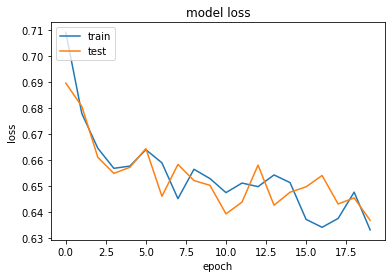

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

model = create_model(
    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, momentum=0.8, nesterov=False, name="SGD"
    )
)
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=20)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = np.round(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.6538461538461539
              precision    recall  f1-score   support

           0       0.64      0.63      0.64        87
           1       0.67      0.67      0.67        95

    accuracy                           0.65       182
   macro avg       0.65      0.65      0.65       182
weighted avg       0.65      0.65      0.65       182



Epoch 1/10
82/82 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5315 - val_loss: 0.6599 - val_accuracy: 0.6301
Epoch 2/10
82/82 [==============================] - 0s 1ms/step - loss: 0.6863 - accuracy: 0.5469 - val_loss: 0.6590 - val_accuracy: 0.6575
Epoch 3/10
82/82 [==============================] - 0s 899us/step - loss: 0.6796 - accuracy: 0.5668 - val_loss: 0.6586 - val_accuracy: 0.6575
Epoch 4/10
82/82 [==============================] - 0s 1ms/step - loss: 0.6774 - accuracy: 0.5960 - val_loss: 0.6600 - val_accuracy: 0.6301
Epoch 5/10
82/82 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.6114 - val_loss: 0.6513 - val_accuracy: 0.6027
Epoch 6/10
82/82 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.6237 - val_loss: 0.6575 - val_accuracy: 0.6164
Epoch 7/10
82/82 [==============================] - 0s 1ms/step - loss: 0.6598 - accuracy: 0.6283 - val_loss: 0.6579 - val_accuracy: 0.6438
Epoch 8/10
82/82 [

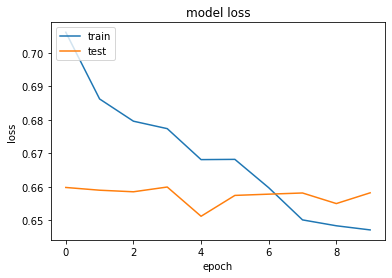

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

model = create_model(optimizer="adam")
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=10)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = np.round(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.6483516483516484
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        87
           1       0.70      0.57      0.63        95

    accuracy                           0.65       182
   macro avg       0.66      0.65      0.65       182
weighted avg       0.66      0.65      0.65       182



The metrics are evaluated on the balanced sub-sample. The higher accuracy is only due to the model being more used to the in-frequent class. Its true test will be on the imbalanced sub-sample, where we will really measure how it discriminates.

In [ ]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced